In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ag-product/Amazon_train.csv
/kaggle/input/ag-product/AG_perfect_matching_test.csv
/kaggle/input/ag-product/AG_perfect_matching_train.csv
/kaggle/input/ag-product/Amazon_test.csv
/kaggle/input/ag-product/Google_train.csv
/kaggle/input/ag-product/Google_test.csv
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.50d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.200d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin


In [2]:
# import pacakges and modules

!pip install recordlinkage 
!pip install textdistance 
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import nltk
import random
import string
import textdistance
import recordlinkage as rl
import collections
from recordlinkage.preprocessing import clean
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
nltk.download('stopwords')


     |████████████████████████████████| 944 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 3.4 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# import the packages about keras

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding,Activation,Flatten,merge,TimeDistributed,GRU,Bidirectional,Dropout,BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import concatenate,subtract,add,maximum,multiply,Layer,Lambda,dot
from keras import backend as K
from sklearn.metrics import log_loss,f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [3]:
# import test data and train data

goog_train = pd.read_csv('/kaggle/input/ag-product/Google_train.csv')
amzn_train = pd.read_csv('/kaggle/input/ag-product/Amazon_train.csv')
goog_test = pd.read_csv('/kaggle/input/ag-product/Google_test.csv')
amzn_test = pd.read_csv('/kaggle/input/ag-product/Amazon_test.csv')
match_train = pd.read_csv('/kaggle/input/ag-product/AG_perfect_matching_train.csv')
match_train.columns = ['id_a','id_g']
match_test = pd.read_csv('/kaggle/input/ag-product/AG_perfect_matching_test.csv')
match_test.columns = ['id_a','id_g']


In [4]:
# clean the data

def clean_ag(goog,amzn): 
    goog['name'] = clean(goog['name'])
    goog['description'] = clean(goog['description'])
    goog['manufacturer'] = clean(goog['manufacturer'])
    goog['price'] = pd.to_numeric(goog['price'], errors='coerce')
    goog.columns = ['idGoogle', 'title', 'description', 'manufacturer', 'price']
    goog = goog.set_index('idGoogle')

    amzn['title'] = clean(amzn['title'])
    amzn['description'] = clean(amzn['description'])
    amzn['manufacturer'] = clean(amzn['manufacturer'])
    amzn.columns = ['idAmazon', 'title', 'description', 'manufacturer', 'price']
    amzn = amzn.set_index('idAmazon')
    
    goog = goog.drop('manufacturer', 1)
    
    
    # combine the column of amazon data
    amzn['title'] = amzn['manufacturer'] + ' ' +  amzn['title']
    amzn = amzn.drop('manufacturer', 1)
    
    return goog, amzn


goog_train, amzn_train = clean_ag(goog = goog_train, amzn = amzn_train)
goog_test, amzn_test = clean_ag(goog = goog_test, amzn = amzn_test)

In [5]:
# define the function that generates the block

def generate_blocks(goog = goog_train, amzn = amzn_train):
    st = set(stopwords.words())  
    words_g = ' '.join(list(goog['title'])).split()
    words_a = ' '.join(list(amzn['title'])).split()
    words_g_no_sw = [word for word in words_g if word not in st]
    words_a_no_sw = [word for word in words_a if word not in st]
    blocks_g = [word for word in words_g_no_sw if  words_g_no_sw.count(word) < 60]
    blocks_a = [word for word in words_a_no_sw if  words_a_no_sw.count(word) < 20]
    blocks = list(set(blocks_a).intersection(blocks_g))
    return blocks

In [6]:
# generate blocks

blocks = generate_blocks()
blocks_test = generate_blocks(goog_test, amzn_test)

In [7]:
# define the function that implements blocking method.

def blockify(blocks, amzn, goog):
    """Attemps record linkage with blocking of Amazon and Google
    product records.
    """

    amzn_blocks = pd.DataFrame(columns=['block_key', 'id_a', 'title_a'])
    goog_blocks = pd.DataFrame(columns=['block_key', 'id_g', 'title_g'])

    amzn_blocks = amzn_blocks.set_index('block_key')
    goog_blocks = goog_blocks.set_index('block_key')
     
  
    for block in blocks:

        for a in amzn.itertuples():
            if block in a.title.split():
                amzn_blocks = amzn_blocks.append(
                    pd.Series({'id_a': a.Index, 'title_a': a.title}, name = block)
                )
                

        for g in goog.itertuples():
            if block in g.title.split():
                goog_blocks = goog_blocks.append(
                    pd.Series({'id_g': g.Index, 'title_g': g.title}, name = block)
                )

                
    return amzn_blocks, goog_blocks

In [8]:
# making pairs

amzn_blocks, goog_blocks = blockify(blocks, amzn_train, goog_train)
ag_pairs = pd.merge(amzn_blocks,goog_blocks, left_index = True, right_index = True, how = 'outer').drop_duplicates()
amzn_blocks_test, goog_blocks_test = blockify(blocks_test, amzn_test, goog_test)
ag_pairs_test = pd.merge(amzn_blocks_test,goog_blocks_test, left_index = True, right_index = True, how = 'outer').drop_duplicates()

In [9]:
# filter the dataset that satisfied setted threshold
ag_select = ag_pairs

# calculate the percentage of positive pair 
ag_overlap = pd.merge(ag_select[['id_a','id_g']], match_train,on=('id_a','id_g'), how = 'inner')

# calculate the class weight
weight_for_0 = (1 / (len(ag_select) - len(ag_overlap)))*(len(ag_select))/2.0 
weight_for_1 = (1 / len(ag_overlap))*(len(ag_select))/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

In [10]:
# add the label to our data

ag_overlap['is_same'] = 1
ag_train = pd.merge(ag_select, ag_overlap, on = ['id_a','id_g'], how = 'left')
ag_train['is_same'] = ag_train['is_same'].fillna(0)



ag_select_test = ag_pairs_test
ag_overlap_test = pd.merge(ag_select_test[['id_a','id_g']], match_test,on=('id_a','id_g'), how = 'inner')
ag_overlap_test['is_same'] = 1
ag_test = pd.merge(ag_select_test, ag_overlap_test, on = ['id_a','id_g'], how = 'left')
ag_test['is_same'] = ag_test['is_same'].fillna(0)



In [11]:
# calculate similarity score for each pair

def similarity_score(name):
    list1 = name[1].split()
    list2 = name[3].split()
    jaccard = textdistance.jaccard(name[1], name[3])
    cosine = textdistance.cosine(name[1], name[3])
    ratcliff = textdistance.ratcliff_obershelp.normalized_similarity(name[1], name[3])
    return (jaccard + cosine + ratcliff) / 3

ag_train['score'] = ag_train.apply(similarity_score, axis = 1)
ag_test['score'] = ag_test.apply(similarity_score, axis = 1)


In [12]:
# finding common words for each pair

def t1_t2_intersect(row):
    words_a = row['title_a'].split()
    words_g = row['title_g'].split()

    intersect = list(set(words_a).intersection(set(words_g)))
    
    return (' '.join(intersect))


ag_train['intersect'] = ag_train.apply(t1_t2_intersect, axis = 1)
ag_test['intersect'] = ag_test.apply(t1_t2_intersect, axis = 1)

In [13]:
# calculate character length of common words for each pair

def t1_t2_intersect_len(row):
    words_a = row['title_a'].split()
    words_g = row['title_g'].split()

    word_set = list(set(words_a).intersection(set(words_g)))
    intersect = ' '.join(word_set)
    length = len(intersect)
    
    return (length)

ag_train['len'] = ag_train.apply(t1_t2_intersect_len, axis = 1)
ag_test['len'] = ag_test.apply(t1_t2_intersect_len, axis = 1)

In [14]:
# calculate difference in length of product title for each pair

def diff_length(row):
    words_a = row['title_a'].split()
    words_g = row['title_g'].split()
    return np.abs(len(words_a) - len(words_g)) 

ag_train['diff'] = ag_train.apply(diff_length, axis = 1)
ag_test['diff'] = ag_test.apply(diff_length, axis = 1)

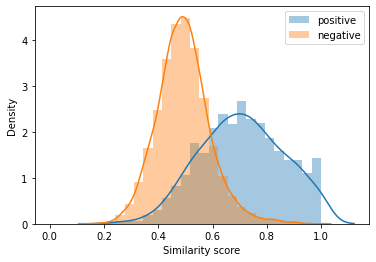

In [15]:
# do data analysis for similarity score

bins = np.linspace(0, 1, 30)
score = sns.distplot(ag_train['score'].loc[ag_train.is_same == 1], bins, label='positive')
score = sns.distplot(ag_train['score'].loc[ag_train.is_same == 0], bins, label='negative')
plt.xlabel("Similarity score")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.show()
score.figure.savefig("score.png")

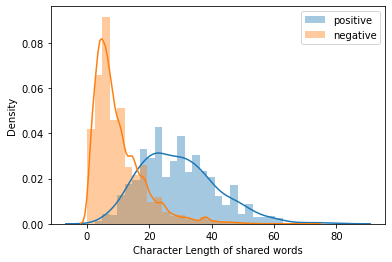

In [16]:
# do data analysis for character length of common words 

bins = np.linspace(0, 70, 30)
length = sns.distplot(ag_train['len'].loc[ag_train.is_same == 1], bins, label='positive')
length = sns.distplot(ag_train['len'].loc[ag_train.is_same == 0], bins, label='negative')
plt.xlabel("Character Length of shared words")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.show()
length.figure.savefig("length.png")

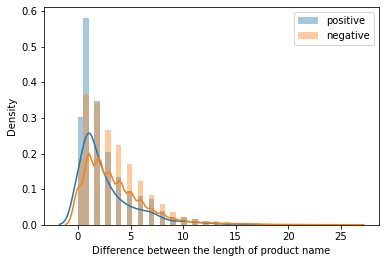

In [17]:
#  do data analysis for difference in length of product title

bins = np.linspace(0, 15, 30)
difference = sns.distplot(ag_train['diff'].loc[ag_train.is_same == 1], bins, label='positive')
difference = sns.distplot(ag_train['diff'].loc[ag_train.is_same == 0], bins, label='negative')
plt.xlabel("Difference between the length of product name")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.show()
difference.figure.savefig("difference.png")

In [19]:
# set the hyperparameter

Max_Length = 25
Max_Words = 10000
nrows = 10000000
Embedding_dim = 300

In [20]:
# tokenize training data and do padding

corpus = []
corpus = ag_train['title_a'].values.tolist() + ag_train['title_g'].values.tolist()
tokenizer = Tokenizer(num_words=Max_Words)
tokenizer.fit_on_texts(corpus)

X_a = tokenizer.texts_to_sequences(ag_train['title_a'])
X_g = tokenizer.texts_to_sequences(ag_train['title_g'])
X_i = tokenizer.texts_to_sequences(ag_train['intersect'])

X_a = pad_sequences(X_a, maxlen=Max_Length)
X_g = pad_sequences(X_g, maxlen=Max_Length)
X_i = pad_sequences(X_i, maxlen=Max_Length)

X_a_test = tokenizer.texts_to_sequences(ag_test['title_a'])
X_g_test = tokenizer.texts_to_sequences(ag_test['title_g'])
X_i_test = tokenizer.texts_to_sequences(ag_test['intersect'])

X_a_test = pad_sequences(X_a_test, maxlen=Max_Length)
X_g_test = pad_sequences(X_g_test, maxlen=Max_Length)
X_i_test = pad_sequences(X_i_test, maxlen=Max_Length)


X_s = ag_train['score']
X_s_test = ag_test['score']

X_l = ag_train['len']
X_l_test = ag_test['len']

X_d = ag_train['diff']
X_d_test = ag_test['diff']

In [21]:
# extract the label and determine the nb_words

y = ag_train['is_same'].values

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
nb_words = min(Max_Words, len(word_index)) + 1

Found 4753 unique tokens


In [22]:
# load pretrained embeddings

glove_dir = '/kaggle/input/glove6b'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.300d.txt')) 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [23]:
# generate the embedding matrix

embedding_matrix = np.zeros((nb_words, Embedding_dim))
for word, i in word_index.items():
    if i < nb_words:
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [112]:
# split the training data

X_train_a,X_val_a,X_train_g,X_val_g,X_train_i,X_val_i,X_train_s,X_val_s,X_train_l,X_val_l,X_train_d,X_val_d,y_train,y_val = train_test_split(X_a,X_g,X_i,X_s,X_l,X_d,y,train_size=0.9,random_state=1024)

X_train = [X_train_a,X_train_g,X_train_i,X_train_s,X_train_l,X_train_d]

X_val = [X_val_a,X_val_g,X_val_i,X_val_s,X_val_l,X_val_d]
X_test = [X_a_test,X_g_test,X_i_test,X_s_test,X_l_test,X_d_test]


print(X_train_a.shape,X_val_a.shape)

(29961, 25) (3329, 25)


In [113]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

         
with tpu_strategy.scope():
    
    # define activation method
    act = 'relu'
    
    
    # define metrics
    METRICS = [
          #keras.metrics.TruePositives(name='tp'),
          #keras.metrics.FalsePositives(name='fp'),
          #keras.metrics.TrueNegatives(name='tn'),
          #keras.metrics.FalseNegatives(name='fn'), 
          #keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
        
    ]
    
    # define input
    input_a = Input(shape=(Max_Length,), dtype='int32')
    input_g = Input(shape=(Max_Length,), dtype='int32')
    input_i = Input(shape=(Max_Length,), dtype='int32')
    input_s = Input(shape=(1,), dtype='int32')
    input_l = Input(shape=(1,), dtype='int32')
    input_d = Input(shape=(1,), dtype='int32')


    if embedding_matrix is not None:
        weights=[embedding_matrix],

        embedding_layer = Embedding(nb_words,
                Embedding_dim,
                input_length = Max_Length,
                weights = [embedding_matrix],
                trainable = False)
    else:
        embedding_layer = Embedding(nb_words,
                Embedding_dim,
                input_length = Max_Length,
                trainable = True)
    
    # obtain embedding sequence
    embedded_sequences_a = embedding_layer(input_a)
    embedded_sequences_g = embedding_layer(input_g)
    embedded_sequences_i = embedding_layer(input_i)

    # define lstm layer
    bilstm_layer_1 = Bidirectional(LSTM(128, dropout = 0.1,recurrent_dropout = 0.1))
    
    # obtain representation
    x1 = bilstm_layer_1(embedded_sequences_a)
    x2 = bilstm_layer_1(embedded_sequences_g)
    x3 = bilstm_layer_1(embedded_sequences_i)
    x4 = Dense(256,activation = act)(input_s)
    x5 = Dense(256,activation = act)(input_l)
    x6 = Dense(256,activation = act)(input_d)
    
    
    # concatenate all outputs
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dropout(0.1)(x)
    x = Dense(256,activation = act,kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.1)(x)
    x = Dense(64,activation = act,kernel_regularizer=regularizers.l2(0.001))(x)
    
    # make final classification
    preds = Dense(1,activation='sigmoid')(x)
    
    # define and complie our model
    model = Model(inputs=[input_a,input_g,input_i,input_s,input_l,input_d],outputs=preds)            
    model.compile(loss = 'mse',
            optimizer = keras.optimizers.Nadam(lr=1e-3),
            metrics = METRICS)
            
            
    print(model.summary())


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 300)      1426200     input_42[0][0]                   
                                                                 input_43[0][0]             

In [114]:
# model fit
early_stopping = EarlyStopping(monitor='val_precision', patience = 15, restore_best_weights = True, mode = 'max')
bst_model_path = 'best_model.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True, monitor='val_precision', mode='max')
model_reducelr = ReduceLROnPlateau(monitor='val_precision', factor=0.3, patience = 6, verbose=0, mode='max', epsilon=0.0001, cooldown=0, min_lr=0.000001)
model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val), batch_size = 256, shuffle=True, verbose=1, callbacks=[early_stopping, model_checkpoint,model_reducelr],class_weight = class_weight)
model.load_weights(bst_model_path)

Epoch 1/50
118/118 [==============================] - 15s 131ms/step - precision: 0.1531 - recall: 0.9029 - loss: 0.3101 - auc: 0.9390 - val_precision: 0.1903 - val_recall: 0.9608 - val_loss: 0.2063 - val_auc: 0.9596 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 7s 62ms/step - precision: 0.2193 - recall: 0.9374 - loss: 0.1438 - auc: 0.9646 - val_precision: 0.2588 - val_recall: 0.9412 - val_loss: 0.1279 - val_auc: 0.9708 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 5s 38ms/step - precision: 0.2565 - recall: 0.9622 - loss: 0.1025 - auc: 0.9726 - val_precision: 0.3151 - val_recall: 0.9020 - val_loss: 0.0911 - val_auc: 0.9732 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 4s 37ms/step - precision: 0.2669 - recall: 0.9644 - loss: 0.0851 - auc: 0.9748 - val_precision: 0.2848 - val_recall: 0.9020 - val_loss: 0.0865 - val_auc: 0.9704 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 4s 37ms/step - precision: 0.3030

118/118 [==============================] - 4s 36ms/step - precision: 0.5585 - recall: 0.9989 - loss: 0.0175 - auc: 0.9913 - val_precision: 0.4762 - val_recall: 0.7843 - val_loss: 0.0324 - val_auc: 0.9678 - lr: 9.0000e-05
Epoch 37/50
118/118 [==============================] - 4s 36ms/step - precision: 0.5634 - recall: 0.9968 - loss: 0.0175 - auc: 0.9916 - val_precision: 0.4841 - val_recall: 0.7451 - val_loss: 0.0317 - val_auc: 0.9678 - lr: 9.0000e-05
Epoch 38/50
118/118 [==============================] - 4s 38ms/step - precision: 0.5607 - recall: 0.9968 - loss: 0.0178 - auc: 0.9914 - val_precision: 0.4837 - val_recall: 0.7255 - val_loss: 0.0308 - val_auc: 0.9678 - lr: 9.0000e-05
Epoch 39/50
118/118 [==============================] - 4s 36ms/step - precision: 0.5740 - recall: 0.9957 - loss: 0.0171 - auc: 0.9918 - val_precision: 0.4756 - val_recall: 0.7647 - val_loss: 0.0322 - val_auc: 0.9674 - lr: 9.0000e-05
Epoch 40/50
118/118 [==============================] - 4s 36ms/step - precision:

In [115]:
# evaluate the model

y_test = ag_test['is_same'].values
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

In [117]:
# generate the confusion matrix
train_predictions = model.predict(X_test)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  m1 = sns.heatmap(cm, annot=True, fmt="d")
  plt.title('')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  m1.figure.savefig("m1.png")
    
plot_cm(y_test, train_predictions)

In [121]:
# get kappa statistics
train_predictions[train_predictions > 0.5] = 1 
train_predictions[train_predictions <= 0.5] = 0 
cohen_kappa_score(y_test, train_predictions)

In [122]:
# plot the precision and recall curve
y_pre = np.concatenate((1-train_predictions,train_predictions ), axis=1)
pr3 = skplt.metrics.plot_precision_recall(y_test,y_pre_3, title = '',classes_to_plot = 1, plot_micro = False ,figsize=(6,6), cmap = 'Blues')
plt.show()
pr3.figure.savefig("pr3.png")

0.7536607470767335